### First 6 boxes are setup, scroll down for results

In [1]:
import sys
sys.path.append('../../lib/')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from jax.example_libraries.optimizers import adam, unpack_optimizer_state, pack_optimizer_state
import pickle

jax.config.update('jax_platform_name', 'cpu')
from hetero_simulation.econ_models.housing import neural_network, renter_policy, owner_policy, econ_config, ml_config, draw_states, loss, params0
from hetero_simulation.archive.agent import log_utility
from hetero_simulation.ml.utils import *
utility = lambda c, h, n: log_utility()(c) + log_utility()(h) + log_utility()(1 - n)

In [2]:
opt_init, opt_update, get_params = adam(step_size=0.001)
saved_params = pickle.load(open(f'../models/housing_model_latest.pkl', 'rb'))
opt_state = pack_optimizer_state(saved_params)
params = get_params(opt_state)

In [3]:
any([jnp.isnan(v).any() for k, v in (params["owner"] | params["renter"]).items()])

False

In [4]:
m = jnp.linspace(0, 2, 10001)
a = jnp.linspace(0, 1, 1001)
b = jnp.linspace(0, 1, 1001)
z = jnp.linspace(0.5, 1.5, 101)
i = jnp.linspace(0.01, 0.1, 101)
t = jnp.linspace(0, econ_config['T'], 101)

In [5]:
z0 = jnp.ones(1)
i0 = econ_config['ibar'] * jnp.ones(1)

In [6]:
a0 = 0. * jnp.ones(1)
b0 = 0. * jnp.ones(1)
o0 = 0. * jnp.ones(1)
t0 = 20. * jnp.ones(1)
v0, c0, h0, n0, m1, a1, b1, o1, bc, l0 = jax.vmap(lambda m0: neural_network(params, z0, i0, m0, a0, b0, o0, t0))(m)
v1f = lambda params, z1, i1, m1, a1, b1, o1, t1: neural_network(params, z1, i1, m1, a1, b1, o1, t1)[0]
v1 = jax.vmap(lambda m1, a1, b1, o1: v1f(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)

v0f = lambda params, z0, i0, m0, a0, b0, o0, t0: neural_network(params, z0, i0, m0, a0, b0, o0, t0)[0][0]
v0_grad = jax.vmap(lambda m0: jax.grad(v0f, (3, 4, 5))(params, z0, i0, m0, a0, b0, o0, t0))(m)
v0 = jax.vmap(lambda m0: v0f(params, z0, i0, m0, a0, b0, o0, t0))(m)
v0m = v0_grad[0]
v0a = v0_grad[1]
v0b = v0_grad[2]

v1f = lambda params, z1, i1, m1, a1, b1, o1, t1: neural_network(params, z1, i1, m1, a1, b1, o1, t1)[0][0]
v1 = jax.vmap(lambda m1, a1, b1, o1: v1f(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)
v1_grad = jax.vmap(lambda m1, a1, b1, o1: jax.grad(v1f, (3, 4, 5))(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)
v1m = v1_grad[0]
v1a = v1_grad[1]
v1b = v1_grad[2]

u = jax.vmap(utility)(c0, h0, n0)
rdf = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), h0.reshape(-1, 1), n0.reshape(-1, 1),
                                   m1.reshape(-1, 1), a1.reshape(-1, 1), b1.reshape(-1, 1),
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), v1.reshape(-1, 1),
                                   l0.reshape(-1, 1), m.reshape(-1, 1), u.reshape(-1, 1),
                                   v0m.reshape(-1, 1), v0a.reshape(-1, 1), v0b.reshape(-1, 1),
                                   v1m.reshape(-1, 1), v1a.reshape(-1, 1), v1b.reshape(-1, 1)),
                                   axis=1))
rdf.columns = ['rc', 'rh', 'rn', 'rm', 'ra', 'rb', 'rbc', 'rv0', 'rv1', 'rl0', 'm0', 'ru', 'rv0m', 'rv0a', 'rv0b', 'rv1m', 'rv1a', 'rv1b']
rdf.set_index('m0', inplace=True)


a0 = 0. * jnp.ones(1)
b0 = 0. * jnp.ones(1)
o0 = jnp.ones(1)
v0, c0, h0, n0, m1, a1, b1, o1, bc, l0 = jax.vmap(lambda m0: neural_network(params, z0, i0, m0, a0, b0, o0, t0))(m)

v0f = lambda params, z0, i0, m0, a0, b0, o0, t0: neural_network(params, z0, i0, m0, a0, b0, o0, t0)[0][0]
v0_grad = jax.vmap(lambda m0: jax.grad(v0f, (3, 4, 5))(params, z0, i0, m0, a0, b0, o0, t0))(m)
v0 = jax.vmap(lambda m0: v0f(params, z0, i0, m0, a0, b0, o0, t0))(m)
v0m = v0_grad[0]
v0a = v0_grad[1]
v0b = v0_grad[2]

v1f = lambda params, z1, i1, m1, a1, b1, o1, t1: neural_network(params, z1, i1, m1, a1, b1, o1, t1)[0][0]
v1 = jax.vmap(lambda m1, a1, b1, o1: v1f(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)
v1_grad = jax.vmap(lambda m1, a1, b1, o1: jax.grad(v1f, (3, 4, 5))(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)
v1m = v1_grad[0]
v1a = v1_grad[1]
v1b = v1_grad[2]

u = jax.vmap(utility)(c0, h0, n0)
odf = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), h0.reshape(-1, 1), n0.reshape(-1, 1),
                                   m1.reshape(-1, 1), a1.reshape(-1, 1), b1.reshape(-1, 1),
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), v1.reshape(-1, 1),
                                   l0.reshape(-1, 1), m.reshape(-1, 1), u.reshape(-1, 1),
                                   v0m.reshape(-1, 1), v0a.reshape(-1, 1), v0b.reshape(-1, 1),
                                   v1m.reshape(-1, 1), v1a.reshape(-1, 1), v1b.reshape(-1, 1)),
                                   axis=1))
odf.columns = ['oc', 'oh', 'on', 'om', 'oa', 'ob', 'obc', 'ov0', 'ov1', 'ol0', 'm0', 'ou', 'ov0m', 'ov0a', 'ov0b', 'ov1m', 'ov1a', 'ov1b']
odf.set_index('m0', inplace=True)

df = rdf.join(odf)

# Main Diagnostic
### Policy of renters and owners as a function of initial cash wealth

The main thing that we want to see here that is difficult to get is that renters should want to save just enough to become homeowners (0.2) if their initial walth is below this.

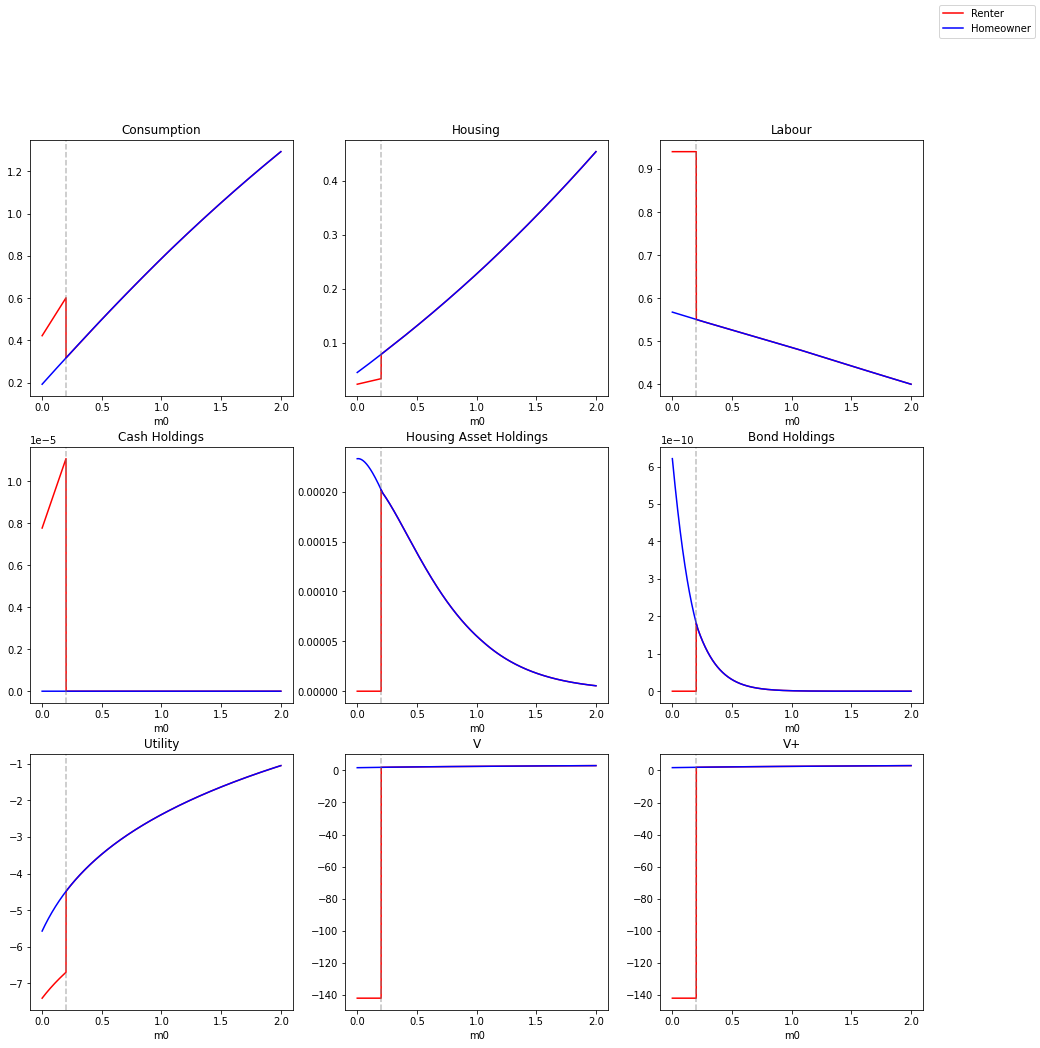

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
_ = df['rc'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='red')
_ = df['rh'].plot(kind='line', ax=axes.flatten()[1], title='Housing', c='red')
_ = df['rn'].plot(kind='line', ax=axes.flatten()[2], title='Labour', c='red')
_ = df['rm'].plot(kind='line', ax=axes.flatten()[3], title='Cash Holdings', c='red')
_ = df['ra'].plot(kind='line', ax=axes.flatten()[4], title='Housing Asset Holdings', c='red')
_ = df['rb'].plot(kind='line', ax=axes.flatten()[5], title='Bond Holdings', c='red')
_ = df['ru'].plot(kind='line', ax=axes.flatten()[6], title='Utility', c='red')
_ = df['rv0'].plot(kind='line', ax=axes.flatten()[7], title='V', c='red')
_ = df['rv1'].plot(kind='line', ax=axes.flatten()[8], title='V+', c='red')

_ = df['oc'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='blue')
_ = df['oh'].plot(kind='line', ax=axes.flatten()[1], title='Housing', c='blue')
_ = df['on'].plot(kind='line', ax=axes.flatten()[2], title='Labour', c='blue')
_ = df['om'].plot(kind='line', ax=axes.flatten()[3], title='Cash Holdings', c='blue')
_ = df['oa'].plot(kind='line', ax=axes.flatten()[4], title='Housing Asset Holdings', c='blue')
_ = df['ob'].plot(kind='line', ax=axes.flatten()[5], title='Bond Holdings', c='blue')
_ = df['ou'].plot(kind='line', ax=axes.flatten()[6], title='Utility', c='blue')
_ = df['ov0'].plot(kind='line', ax=axes.flatten()[7], title='V', c='blue')
_ = df['ov1'].plot(kind='line', ax=axes.flatten()[8], title='V+', c='blue')

_ = fig.legend(['Renter', 'Homeowner'])
for ax in axes.flatten():
    ax.axvline(x=(econ_config['phi']*econ_config['pa']), color='grey', linestyle='--', alpha=0.5)

### Derivative of the value function for both types w.r.t future and current values of each asset

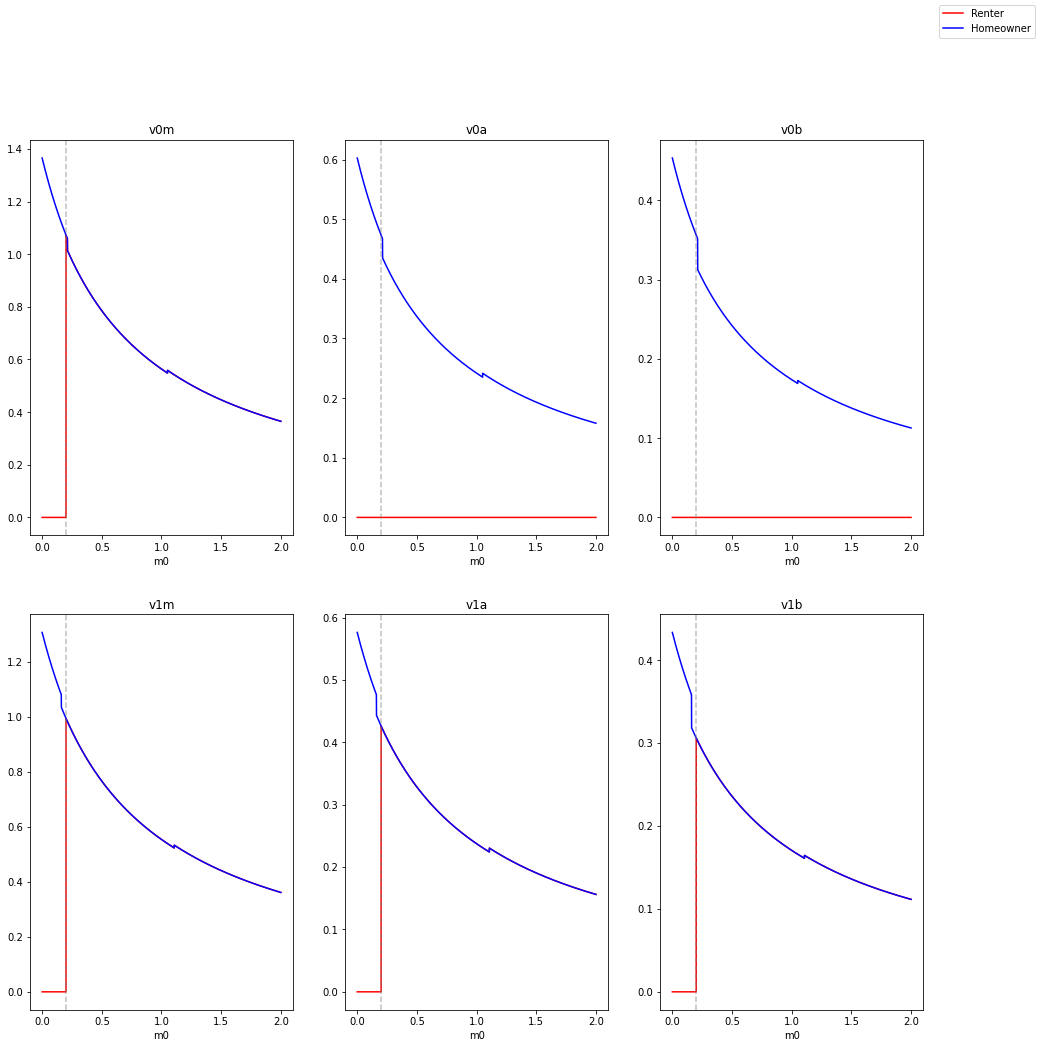

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(16,16))
_ = df['rv0m'].plot(kind='line', ax=axes.flatten()[0], title='v0m', c='red')
_ = df['rv0a'].plot(kind='line', ax=axes.flatten()[1], title='v0a', c='red')
_ = df['rv0b'].plot(kind='line', ax=axes.flatten()[2], title='v0b', c='red')
_ = df['rv1m'].plot(kind='line', ax=axes.flatten()[3], title='v1m', c='red')
_ = df['rv1a'].plot(kind='line', ax=axes.flatten()[4], title='v1a', c='red')
_ = df['rv1b'].plot(kind='line', ax=axes.flatten()[5], title='v1b', c='red')

_ = df['ov0m'].plot(kind='line', ax=axes.flatten()[0], title='v0m', c='blue')
_ = df['ov0a'].plot(kind='line', ax=axes.flatten()[1], title='v0a', c='blue')
_ = df['ov0b'].plot(kind='line', ax=axes.flatten()[2], title='v0b', c='blue')
_ = df['ov1m'].plot(kind='line', ax=axes.flatten()[3], title='v1m', c='blue')
_ = df['ov1a'].plot(kind='line', ax=axes.flatten()[4], title='v1a', c='blue')
_ = df['ov1b'].plot(kind='line', ax=axes.flatten()[5], title='v1b', c='blue')

_ = fig.legend(['Renter', 'Homeowner'])
for ax in axes.flatten():
    ax.axvline(x=(econ_config['phi']*econ_config['pa']), color='grey', linestyle='--', alpha=0.5)

#### Difference between renter and owner value as a function of cash wealth

<AxesSubplot:xlabel='m0'>

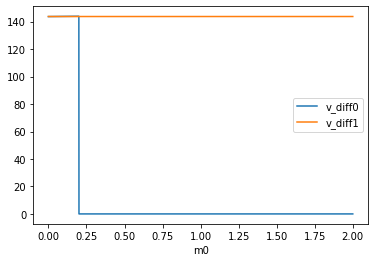

In [11]:
@jax.jit
def v_diff(params, z0, i0, m0, t0):
    ov0, _, _, _, om1, oa1, ob1, _, _, _ = neural_network(params, z0, i0, m0, 0., 0., 1., t0)
    rv0, _, _, _, rm1, ra1, rb1, _, _, _ = neural_network(params, z0, i0, m0, 0., 0., 0., t0)
    
    ov1 = neural_network(params, z0, i0, om1, oa1, ob1, 1., t0 + 1)[0]
    rv1 = neural_network(params, z0, i0, rm1, ra1, rb1, 0., t0 + 1)[0]
    
    return (ov0 - rv0, ov1 - rv1)

v_diff0, v_diff1 = jax.vmap(v_diff, in_axes=(None, None, None, 0, None))(params, z0, i0, m, t0)
v_diff_df = pd.DataFrame(jnp.concatenate((m.reshape(-1, 1), v_diff0.reshape(-1, 1), v_diff1.reshape(-1, 1)), axis=1))
v_diff_df.columns = ['m0', 'v_diff0', 'v_diff1']
v_diff_df.set_index('m0').plot()

### Total savings of renters and homeowners as a function of initial cash wealth

<AxesSubplot:xlabel='m0'>

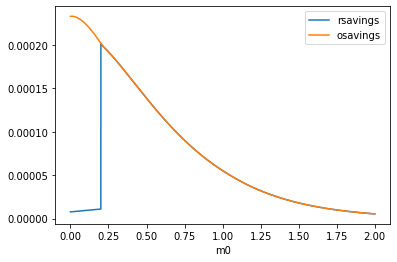

In [12]:
df['rsavings'] = df['rm'] + df['ra']
df['rsavings'] = df['rsavings'] + df['rb']
df['osavings'] = df['oa'] + df['ob']
df[['rsavings', 'osavings']].plot()

### Policy as a function of asset wealth for owners

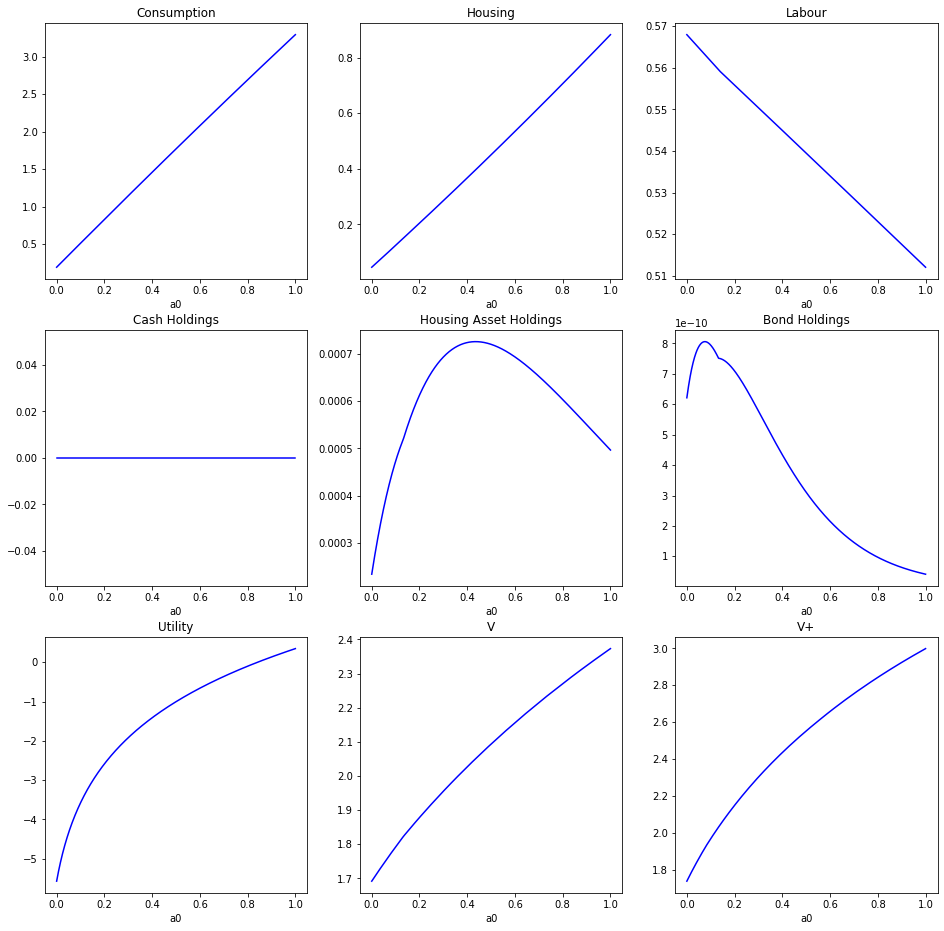

In [13]:
m = jnp.linspace(0, 2, 1001)
     
m0 = jnp.zeros(1)
o0 = jnp.ones(1)
v0, c0, h0, n0, m1, a1, b1, o1, bc, l0 = jax.vmap(lambda a0, b0: neural_network(params, z0, i0, m0, a0, b0, o0, t0))(a, b)
v1 = jax.vmap(lambda m1, a1, b1, o1: v1f(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)
u = utility(c0, h0, n0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), h0.reshape(-1, 1), n0.reshape(-1, 1),
                                   m1.reshape(-1, 1), a1.reshape(-1, 1), b1.reshape(-1, 1),
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), v1.reshape(-1, 1),
                                   l0.reshape(-1, 1), a.reshape(-1, 1), u.reshape(-1, 1)),
                                   axis=1))
df.columns = ['c', 'h', 'n', 'm', 'a', 'b', 'bc', 'v0', 'v1', 'l0', 'a0', 'u']
df.set_index('a0', inplace=True)

fig, axes = plt.subplots(3, 3, figsize=(16,16))
_ = df['c'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='blue')
_ = df['h'].plot(kind='line', ax=axes.flatten()[1], title='Housing', c='blue')
_ = df['n'].plot(kind='line', ax=axes.flatten()[2], title='Labour', c='blue')
_ = df['m'].plot(kind='line', ax=axes.flatten()[3], title='Cash Holdings', c='blue')
_ = df['a'].plot(kind='line', ax=axes.flatten()[4], title='Housing Asset Holdings', c='blue')
_ = df['b'].plot(kind='line', ax=axes.flatten()[5], title='Bond Holdings', c='blue')
_ = df['u'].plot(kind='line', ax=axes.flatten()[6], title='Utility', c='blue')
_ = df['v0'].plot(kind='line', ax=axes.flatten()[7], title='V', c='blue')
_ = df['v1'].plot(kind='line', ax=axes.flatten()[8], title='V+', c='blue')

### Show policy over the lifecycle for a representative renter and homeowner

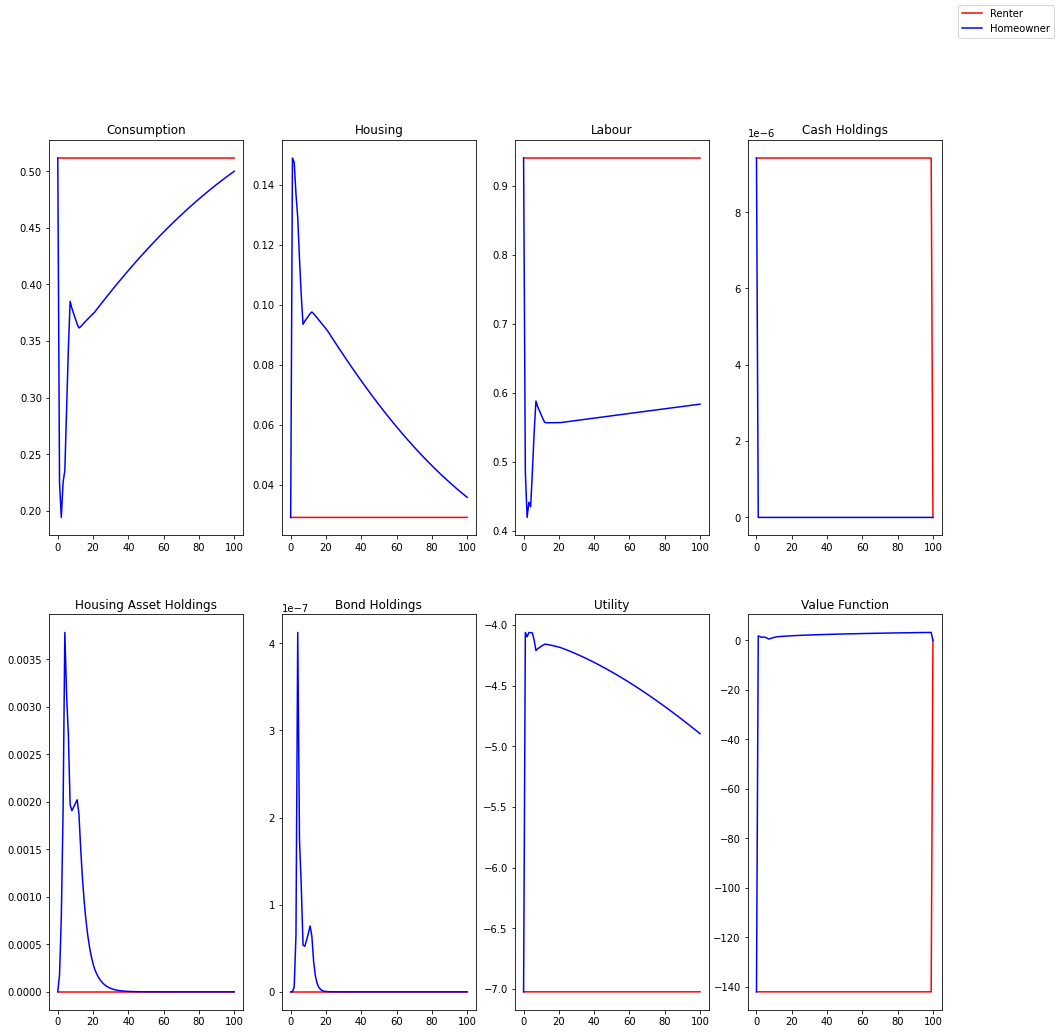

In [14]:
a0 = 0. * jnp.ones(1)
b0 = 0. * jnp.ones(1)
m0 = 0.1 * jnp.ones(1)
o0 = 0. * jnp.ones(1)
v0, c0, h0, n0, m1, a1, b1, o1, bc, l0 = jax.vmap(lambda t0: neural_network(params, z0, i0, m0, a0, b0, o0, t0))(t)
u = utility(c0, h0, n0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), h0.reshape(-1, 1), n0.reshape(-1, 1),
                                   m1.reshape(-1, 1), a1.reshape(-1, 1), b1.reshape(-1, 1),
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), u.reshape(-1, 1)),
                                   axis=1))
df.columns = ['c', 'h', 'n', 'm', 'a', 'b', 'bc', 'v', 'u']

fig, axes = plt.subplots(2, 4, figsize=(16,16))
_ = df['c'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='red')
_ = df['h'].plot(kind='line', ax=axes.flatten()[1], title='Housing', c='red')
_ = df['n'].plot(kind='line', ax=axes.flatten()[2], title='Labour', c='red')
_ = df['m'].plot(kind='line', ax=axes.flatten()[3], title='Cash Holdings', c='red')
_ = df['a'].plot(kind='line', ax=axes.flatten()[4], title='Housing Asset Holdings', c='red')
_ = df['b'].plot(kind='line', ax=axes.flatten()[5], title='Bond Holdings', c='red')
_ = df['u'].plot(kind='line', ax=axes.flatten()[6], title='Utility', c='red')
_ = df['v'].plot(kind='line', ax=axes.flatten()[7], title='Value Function', c='red')

a0 = 0.03 * jnp.ones(1)
b0 = 0.05 * jnp.ones(1)
m0 = 0.1 ** jnp.ones(1)
o0 = 1. * jnp.ones(1)
v0, c0, h0, n0, m1, a1, b1, o1, bc, l0 = jax.vmap(lambda t0: neural_network(params, z0, i0, m0, a0, b0, o0, t0))(t)
u = utility(c0, h0, n0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), h0.reshape(-1, 1), n0.reshape(-1, 1),
                                   m1.reshape(-1, 1), a1.reshape(-1, 1), b1.reshape(-1, 1),
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), u.reshape(-1, 1)),
                                   axis=1))
df.columns = ['c', 'h', 'n', 'm', 'a', 'b', 'bc', 'v', 'u']
_ = df['c'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='blue')
_ = df['h'].plot(kind='line', ax=axes.flatten()[1], title='Housing', c='blue')
_ = df['n'].plot(kind='line', ax=axes.flatten()[2], title='Labour', c='blue')
_ = df['m'].plot(kind='line', ax=axes.flatten()[3], title='Cash Holdings', c='blue')
_ = df['a'].plot(kind='line', ax=axes.flatten()[4], title='Housing Asset Holdings', c='blue')
_ = df['b'].plot(kind='line', ax=axes.flatten()[5], title='Bond Holdings', c='blue')
_ = df['u'].plot(kind='line', ax=axes.flatten()[6], title='Utility', c='blue')
_ = df['v'].plot(kind='line', ax=axes.flatten()[7], title='Value Function', c='blue')

_ = fig.legend(['Renter', 'Homeowner'])